In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta
import pandas_datareader.data as web
import utils

In [2]:
# from utils.data_scraper import download_sp500_tickers 
# sp500_list = download_sp500_tickers(save_local=True)

# from utils.data_scraper import download_sp500_data

# download_sp500_data(sp500_list, save_local=True)

In [3]:
models = utils.models
data_scraper = utils.data_scraper

In [4]:
df = data_scraper.get_sp500_data()
df.dropna(inplace=True)
df = df[df.index.get_level_values('ticker') != 'SPY']
sp500_list = data_scraper.get_sp500_tickers()
sp500_list = [ticker for ticker in sp500_list if ticker != 'SPY']

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:130: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Loaded 504 tickers from local file.


In [5]:
df

adj_close       close        high         low        open  \
date       ticker                                                               
2015-01-05 A        36.425377   39.799999   40.459999   39.700001   40.320000   
           AAPL     23.554741   26.562500   27.162500   26.352501   27.072500   
           ABBV     41.299294   64.650002   66.099998   63.880001   65.500000   
           ABT      36.426781   44.910000   45.400002   44.630001   44.799999   
           ACGL     18.428413   19.379999   19.500000   19.333332   19.393333   
...                       ...         ...         ...         ...         ...   
2025-10-30 XYZ      73.919998   73.919998   76.470001   73.714996   76.470001   
           YUM     139.059998  139.059998  140.029999  137.369995  139.050003   
           ZBH      99.559998   99.559998   99.989998   98.739998   99.169998   
           ZBRA    261.369995  261.369995  268.299988  260.450012  267.839996   
           ZTS     143.600006  144.100006  145.039993  142.440002  142.440002   

                        volume  
date       ticker               
2015-01-05 A         2041800.0  
           AAPL    257142000.0  
           ABBV      8007400.0  
           ABT       5735900.0  
           ACGL      1095900.0  
...                        ...  
2025-10-30 XYZ       6301800.0  
           YUM       2065300.0  
           ZBH       1416100.0  
           ZBRA       943700.0  
           ZTS       2476000.0  

[1323445 rows x 6 columns]

In [6]:
def safe_bbands(series, length=20):
	bb = pandas_ta.bbands(close=np.log1p(series), length=length)
	if bb is not None:
		return bb
	# Return a DataFrame of NaNs with the same index if bb is None
	return pd.DataFrame(np.nan, index=series.index, columns=['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0'])

df['garman_klass_volatility'] = ((np.log(df['high'] - np.log(df['low']) ** 2))/2 - (2 * np.log(2) - 1) * (np.log(df['adj_close']) - np.log(df['open']) ** 2))
df['rsi'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: pandas_ta.rsi(x, length=20))
df['bb_low'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,1])
df['bb_high'] = df.groupby(level='ticker')['adj_close'].transform(lambda x: safe_bbands(x, length=20).iloc[:,2])

c:\Users\kudam\anaconda3\envs\finance-env\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='date'>

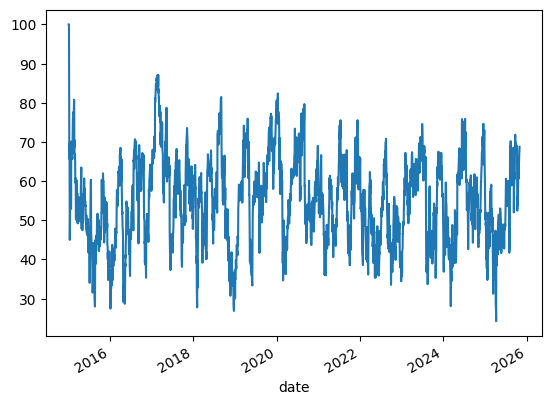

In [7]:
# All 'close' prices for ticker 'AAPL' across all dates
df.xs('AAPL', level='ticker')['rsi'].plot()

In [8]:
df.xs('A', level='ticker').head()

,adj_close,close,high,low,open,volume,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high
date,,,,,,,,,,,
2015-01-05,36.425377,39.799999,40.459999,39.700001,40.320000,2041800.0,5.536737,NaN,NaN,NaN,NaN
2015-01-06,35.857956,39.180000,40.020000,39.020000,39.810001,2080600.0,5.500655,0.000000,NaN,NaN,NaN
2015-01-07,36.333862,39.700001,39.810001,39.290001,39.520000,3359700.0,5.469849,4.227684,NaN,NaN,NaN
2015-01-08,37.422966,40.889999,40.980000,40.180000,40.240002,2116300.0,5.528581,13.079805,NaN,NaN,NaN
2015-01-09,37.148411,40.590000,41.000000,40.290001,41.000000,1644900.0,5.584968,12.766677,NaN,NaN,NaN


In [9]:
def compute_atr(stock_data: pd.DataFrame, period: int = 14) -> pd.Series:
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj_close'], length=period)
    return atr.sub(atr.mean()).div(atr.std())

In [10]:
df = df.dropna()
df['atr'] = df.groupby(level='ticker', group_keys=False).apply(compute_atr)

In [11]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

In [12]:
df['macd'] = df.groupby(level='ticker', group_keys=False)['adj_close'].apply(compute_macd)

In [13]:
df['dollar_volume'] = (df['volume'] * df['adj_close'])/1e6
df['close_over_open'] = np.log(df['adj_close'] / df['open'])

In [14]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = pd.concat([df.unstack(level='ticker')['dollar_volume'].resample('ME').mean().stack(level='ticker', future_stack=True).to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('ME').last().stack(level='ticker', future_stack=True)], axis=1).dropna()

In [15]:
data

dollar_volume   adj_close  garman_klass_volatility  \
date       ticker                                                       
2015-03-31 A           77.421103   38.120670                 5.605968   
           AAPL      5801.357270   27.693962                 4.809874   
           ABBV       498.025787   37.676891                 6.840715   
           ABT        197.810379   37.777473                 6.049622   
           ACGL        27.594328   19.525116                 3.633791   
...                          ...         ...                      ...   
2025-10-31 GEHC       242.242275   75.000000                 7.675149   
           KVUE       481.610112   14.062851                 2.721821   
           VLTO       145.021392  100.379997                 8.584343   
           SOLV        63.672486   69.279999                 7.302465   
           GEV       1926.315527  574.070007                16.258071   

                         rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                      
2015-03-31 A       49.679718  3.636924  3.663416  3.689908 -0.550844   
           AAPL    51.023369  3.337974  3.365978  3.393981 -0.178803   
           ABBV    46.288689  3.594490  3.651795  3.709099  0.516548   
           ABT     45.394840  3.651617  3.671048  3.690480  0.599267   
           ACGL    55.266748  2.986109  3.020091  3.054073 -1.079798   
...                      ...       ...       ...       ...       ...   
2025-10-31 GEHC    49.330688  4.274180  4.333853  4.393527  0.422078   
           KVUE    33.204788  2.686337  2.786264  2.886190 -1.398187   
           VLTO    38.786098  4.610472  4.646356  4.682239  0.138186   
           SOLV    39.357799  4.255035  4.287883  4.320732 -1.301684   
           GEV     43.636180  6.325296  6.399494  6.473693  1.651594   

                       macd  close_over_open  
date       ticker                             
2015-03-31 A      -0.049307        -0.079621  
           AAPL   -0.266508        -0.129487  
           ABBV   -0.297617        -0.431568  
           ABT    -0.137114        -0.214811  
           ACGL   -0.002140        -0.060523  
...                     ...              ...  
2025-10-31 GEHC    0.421687        -0.031240  
           KVUE   -1.739284        -0.020910  
           VLTO   -1.142906         0.008303  
           SOLV   -0.521412        -0.005614  
           GEV    -1.584256         0.007115  

[62194 rows x 10 columns]

In [16]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())
data['dollar_vol_rank'] = data.groupby(level='date')['dollar_volume'].rank(ascending=False)

In [17]:
data = data[data['dollar_vol_rank'] <= 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

**Calculate Monthly Returns for different time horizons as features**

In [18]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2020-02-29 AAPL     66.112671                 7.056595  34.635088  4.221236   
           ABBV     67.732246                 8.003115  43.432005  4.171676   
           ABT      69.579674                 7.699337  26.562324  4.281571   
           ACN     166.075134                10.974559  24.475355  5.156322   
           ADBE    345.119995                13.528691  45.805778  5.830231   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      48.970001                 6.165864  42.347163  3.909562   
           MRNA     28.139999                 4.128776  55.102532  3.262788   
           UBER     96.489998                 8.432315  52.983148  4.519882   
           CRWD    538.679993                16.007218  64.030915  6.150510   
           DDOG    157.070007                10.323562  57.130258  5.017158   

                     bb_mid   bb_high       atr      macd  close_over_open  
date       ticker                                                           
2020-02-29 AAPL    4.332128  4.443020 -0.281471 -0.944593         0.027567  
           ABBV    4.282662  4.393647  0.273644 -0.154294        -0.200745  
           ABT     4.371019  4.460466  0.574250 -1.774731        -0.102890  
           ACN     5.254162  5.352003  0.345903 -1.111200        -0.081960  
           ADBE    5.901527  5.972823  0.261078 -0.060075         0.061853  
...                     ...       ...       ...       ...              ...  
2025-10-31 TTD     3.972026  4.034490 -0.034421 -0.083662        -0.011875  
           MRNA    3.329764  3.396739 -0.829109 -0.002780         0.141585  
           UBER    4.565438  4.610994  1.190897 -0.229220         0.011256  
           CRWD    6.231123  6.311737  1.494879  1.870968        -0.008190  
           DDOG    5.064711  5.112263  0.094334  0.642797         0.013266  

[10350 rows x 9 columns]

In [19]:
def calculate_monthly_returns(df: pd.DataFrame, outlier_cutoffs: float = 0.005) -> pd.DataFrame:
    lags = [1, 2, 3, 6, 9, 12]
    
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj_close'].pct_change(lag)
                                   .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoffs), upper=x.quantile(1 - outlier_cutoffs)))
                                   .add(1)
                                   .pow(1/lag)
                                   .sub(1)
                                   )
    return df

data = data.groupby(level='ticker', group_keys=False).apply(calculate_monthly_returns).dropna()


In [20]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2021-02-28 AAPL    118.217247                 9.401131  36.515188  4.782029   
           ABBV     89.693932                 8.953130  54.185344  4.451670   
           ABT     109.876732                 9.405494  51.778718  4.695131   
           ACN     234.333237                12.466395  47.047014  5.436857   
           ADBE    459.670013                15.213833  41.726510  6.121454   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      48.970001                 6.165864  42.347163  3.909562   
           MRNA     28.139999                 4.128776  55.102532  3.262788   
           UBER     96.489998                 8.432315  52.983148  4.519882   
           CRWD    538.679993                16.007218  64.030915  6.150510   
           DDOG    157.070007                10.323562  57.130258  5.017158   

                     bb_mid   bb_high       atr      macd  close_over_open  \
date       ticker                                                            
2021-02-28 AAPL    4.860659  4.939289  0.890498 -1.335623        -0.036321   
           ABBV    4.489164  4.526657  0.144019 -0.115856        -0.182761   
           ABT     4.738973  4.782814  1.585762  1.107074        -0.106218   
           ACN     5.473474  5.510092  0.755099 -0.051397        -0.085460   
           ADBE    6.180229  6.239005  0.673967 -0.478983        -0.006786   
...                     ...       ...       ...       ...              ...   
2025-10-31 TTD     3.972026  4.034490 -0.034421 -0.083662        -0.011875   
           MRNA    3.329764  3.396739 -0.829109 -0.002780         0.141585   
           UBER    4.565438  4.610994  1.190897 -0.229220         0.011256   
           CRWD    6.231123  6.311737  1.494879  1.870968        -0.008190   
           DDOG    5.064711  5.112263  0.094334  0.642797         0.013266   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2021-02-28 AAPL    -0.079712  -0.043326   0.006651  -0.009780   0.048633   
           ABBV     0.051327   0.008596   0.013895   0.024107   0.021104   
           ABT     -0.030828   0.048040   0.035796   0.016358   0.027464   
           ACN      0.037120  -0.018261   0.003557   0.008709   0.025845   
           ADBE     0.001962  -0.041293  -0.013273  -0.018253   0.019422   
...                      ...        ...        ...        ...        ...   
2025-10-31 TTD     -0.000816  -0.053479  -0.174209  -0.015036  -0.093468   
           MRNA     0.089431   0.080796  -0.016276  -0.002350  -0.037597   
           UBER    -0.015107   0.014508   0.032155   0.029573   0.041619   
           CRWD     0.098495   0.127551   0.058222   0.038726   0.034182   
           DDOG     0.103020   0.071998   0.039144   0.073967   0.010710   

                   return_12m  
date       ticker              
2021-02-28 AAPL      0.049622  
           ABBV      0.023679  
           ABT       0.038241  
           ACN       0.029108  
           ADBE      0.024172  
...                       ...  
2025-10-31 TTD      -0.070762  
           MRNA     -0.054271  
           UBER      0.024639  
           CRWD      0.050906  
           DDOG      0.018915  

[8175 rows x 15 columns]

Download Fama-French Factors and Calculate Rolling Betas

In [21]:
# utils.data_scraper.download_famafrench_data(save_local=True)

In [22]:
factor_data = data_scraper.get_famafrench_data()
factor_data

Loaded Fama-French factors from 'data/famafrench_factors.csv'


,mkt_rf,smb,hml,rmw,cma
date,,,,,
2016-01-31,-0.0574,-0.0344,0.0208,0.0278,0.0305
2016-02-29,-0.0007,0.0087,-0.0061,0.0331,0.0194
2016-03-31,0.0695,0.0100,0.0122,0.0068,0.0001
2016-04-30,0.0091,0.0123,0.0322,-0.0285,0.0177
2016-05-31,0.0178,-0.0062,-0.0162,-0.0110,-0.0254
...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208


In [23]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

mkt_rf     smb     hml     rmw     cma  return_1m
date       ticker                                                   
2021-02-28 AAPL    0.0281  0.0450  0.0720  0.0033 -0.0199  -0.079712
           ABBV    0.0281  0.0450  0.0720  0.0033 -0.0199   0.051327
           ABT     0.0281  0.0450  0.0720  0.0033 -0.0199  -0.030828
           ACN     0.0281  0.0450  0.0720  0.0033 -0.0199   0.037120
           ADBE    0.0281  0.0450  0.0720  0.0033 -0.0199   0.001962
...                   ...     ...     ...     ...     ...        ...
2025-09-30 WFC     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.019956
           WMT     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.062693
           XOM     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.013474
           XYZ     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.092541
           ZTS     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.064450

[8033 rows x 6 columns]

In [24]:
observations = factor_data.groupby(level='ticker').size()
valid_stocks = observations[observations >= 12]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

mkt_rf     smb     hml     rmw     cma  return_1m
date       ticker                                                   
2021-02-28 AAPL    0.0281  0.0450  0.0720  0.0033 -0.0199  -0.079712
           ABBV    0.0281  0.0450  0.0720  0.0033 -0.0199   0.051327
           ABT     0.0281  0.0450  0.0720  0.0033 -0.0199  -0.030828
           ACN     0.0281  0.0450  0.0720  0.0033 -0.0199   0.037120
           ADBE    0.0281  0.0450  0.0720  0.0033 -0.0199   0.001962
...                   ...     ...     ...     ...     ...        ...
2025-09-30 WFC     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.019956
           WMT     0.0339 -0.0218 -0.0105 -0.0203 -0.0222   0.062693
           XOM     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.013474
           XYZ     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.092541
           ZTS     0.0339 -0.0218 -0.0105 -0.0203 -0.0222  -0.064450

[7976 rows x 6 columns]

In [25]:
from utils.models import calculate_betas

betas = calculate_betas(factor_data, method='rls')


In [26]:
betas

mkt_rf       smb       hml       rmw       cma
date       ticker                                                  
2021-02-28 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2025-09-30 WFC     0.861108 -0.136512  0.470968 -1.520548 -0.045252
           WMT     0.536291  0.053047 -0.336946  0.295511 -0.920762
           XOM     0.439935 -0.253888  0.863468  0.475679  0.383460
           XYZ     1.901151  0.494816 -0.341409 -3.527521 -0.265780
           ZTS     0.937100  0.322069  0.908105  1.701469 -0.277009

[7976 rows x 5 columns]

In [27]:
factors = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma']
group_data = data.join(betas.groupby(level='ticker').shift())
group_data.loc[:, factors] = group_data.groupby(level='ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [28]:
group_data = group_data.dropna()
group_data = group_data.drop('adj_close', axis=1)

In [29]:
group_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7905 entries, (Timestamp('2021-02-28 00:00:00'), 'AAPL') to (Timestamp('2025-10-31 00:00:00'), 'TTD')
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   garman_klass_volatility  7905 non-null   float64
 1   rsi                      7905 non-null   float64
 2   bb_low                   7905 non-null   float64
 3   bb_mid                   7905 non-null   float64
 4   bb_high                  7905 non-null   float64
 5   atr                      7905 non-null   float64
 6   macd                     7905 non-null   float64
 7   close_over_open          7905 non-null   float64
 8   return_1m                7905 non-null   float64
 9   return_2m                7905 non-null   float64
 10  return_3m                7905 non-null   float64
 11  return_6m                7905 non-null   float64
 12  return_9m                7905 non-null   float64
 13  

In [30]:
# Prepare supervised target and features (assumes `data` exists)
feature_data = group_data.copy()
feature_data['target_1m'] = feature_data.groupby('ticker')['return_1m'].shift(-1)

features = [
    'rsi', 'garman_klass_volatility', 'close_over_open',
    'atr', 'macd', 'bb_low', 'bb_mid', 'bb_high',
    'return_1m', 'return_2m', 'return_3m', 'return_6m', 'return_9m',
    'mkt_rf', 'smb', 'hml', 'rmw', 'cma'
]

# features = [
#     'rsi', 'garman_klass_volatility', 'atr', 'macd',
#     'bb_low', 'bb_mid', 'bb_high',
#     'return_1m', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma'
# ]

model_df = feature_data.reset_index().dropna(subset=features + ['target_1m'])

from utils.models import rolling_train_predict_windowed
# Run the windowed rolling trainer
fixed_dates_pred, preds_df, last_model, scaler = rolling_train_predict_windowed(
    model_df, features,
    top_k=15, model_type='ridge', tune_model=True,
    window_months=12, min_train_rows=150
)

# Use this mapping for downstream optimisation / backtest
# Offset the dates by 1 day so they start at the beginning of each month
fixed_dates = {}
for d, tickers in fixed_dates_pred.items():
    # Parse date, add 1 day, then set to first day of the month
    new_date = (pd.to_datetime(d) + pd.DateOffset(days=1)).replace(day=1)
    fixed_dates[new_date.strftime('%Y-%m-%d')] = tickers
print(f'Created fixed_dates for {len(fixed_dates)} months')


# Optional: show last model interpretability
if last_model is not None:
    try:
        if hasattr(last_model, 'coef_'):
            coeffs = pd.Series(last_model.coef_, index=features).sort_values(ascending=False)
            print('Ridge coefficients (last model):')
            print(coeffs)
        elif hasattr(last_model, 'feature_importances_'):
            imps = pd.Series(last_model.feature_importances_, index=features).sort_values(ascending=False)
            print('Feature importances (last model):')
            print(imps)
    except Exception as e:
        print('Model inspection error:', e)
else:
    print('No model trained (insufficient history).')

Created fixed_dates for 54 months
Ridge coefficients (last model):
garman_klass_volatility    0.009500
return_2m                  0.009380
mkt_rf                     0.008571
return_1m                  0.006516
macd                       0.005382
return_9m                  0.004159
smb                        0.003922
hml                        0.002644
atr                        0.001459
bb_high                   -0.000975
rmw                       -0.001754
return_6m                 -0.003007
close_over_open           -0.003656
bb_mid                    -0.004269
cma                       -0.004324
bb_low                    -0.007535
rsi                       -0.009654
return_3m                 -0.012957
dtype: float64


In [31]:
# Add next month predictions
future_investment_data = group_data.copy()
future_investment = future_investment_data.drop('return_1m', axis=1).groupby('ticker')

# print('feature_data info', feature_data.info())
future_model_df = future_investment_data.reset_index().dropna(subset=features)

last_date = future_model_df['date'].max()
print('last_date', last_date)
future_date = last_date + pd.DateOffset(days=1)
print(future_date)
pool = future_model_df[future_model_df['date'] == last_date].dropna(subset=features).copy()

X_pred = scaler.transform(pool[features])
y_pred = last_model.predict(X_pred)

pool = pool.assign(y_pred=y_pred)

selected = pool[pool['y_pred'] > 0].nlargest(10, 'y_pred')
fixed_dates[future_date.strftime('%Y-%m-%d')] = selected['ticker'].tolist()

last_date 2025-10-31 00:00:00
2025-11-01 00:00:00


In [32]:
fixed_dates

{'2021-05-01': ['QCOM',
  'TSLA',
  'DD',
  'AMGN',
  'GILD',
  'TMO',
  'REGN',
  'MO',
  'NEE',
  'VRTX',
  'VZ',
  'CVS',
  'MMM',
  'COST',
  'NKE'],
 '2021-06-01': ['T',
  'MO',
  'VZ',
  'DE',
  'MU',
  'SLB',
  'CVX',
  'USB',
  'F',
  'EOG',
  'AMGN',
  'COP',
  'MAR',
  'XOM',
  'CAT'],
 '2021-07-01': ['VZ',
  'T',
  'MO',
  'AMGN',
  'BKNG',
  'INTC',
  'LUV',
  'LMT',
  'EOG',
  'LVS',
  'CVX',
  'DD',
  'PFE',
  'MMM',
  'NEM'],
 '2021-08-01': ['VZ',
  'UPS',
  'FDX',
  'T',
  'NEM',
  'LMT',
  'BKNG',
  'ORCL',
  'META',
  'HUM',
  'AMGN',
  'BLK',
  'IBM',
  'NOC',
  'NEE'],
 '2021-09-01': ['NVDA',
  'AMZN',
  'META',
  'FDX',
  'VZ',
  'UPS',
  'HUM',
  'TSLA',
  'T',
  'AMD',
  'BKNG',
  'MA',
  'AMGN',
  'CRM',
  'HD'],
 '2021-10-01': ['FDX',
  'VZ',
  'JNJ',
  'PFE',
  'BMY',
  'KO',
  'T',
  'MO',
  'TSLA',
  'WMT',
  'UNP',
  'HUM',
  'META',
  'CSCO',
  'AVGO'],
 '2021-11-01': ['TSLA',
  'META',
  'MO',
  'IBM',
  'T',
  'BIIB',
  'AMZN',
  'VZ',
  'LMT',
  'NVDA',

In [33]:
selected

,date,ticker,garman_klass_volatility,rsi,bb_low,bb_mid,bb_high,atr,macd,close_over_open,...,return_3m,return_6m,return_9m,return_12m,mkt_rf,smb,hml,rmw,cma,y_pred
7786,2025-10-31,AMD,12.529184,68.238891,5.232426,5.445397,5.658368,3.474304,6.339852,-0.019738,...,0.130655,0.159118,0.088802,0.048676,1.629720,-0.412409,-0.717709,-0.358515,-0.685095,0.076464
7903,2025-10-31,XYZ,7.633506,45.376373,4.303536,4.360456,4.417376,-0.341163,0.030467,-0.033915,...,-0.014623,0.039852,-0.022618,0.001825,2.637781,0.256659,0.179764,-3.711391,0.491384,0.048422
7904,2025-10-31,TTD,6.165864,42.347163,3.909562,3.972026,4.034490,-0.034421,-0.083662,-0.011875,...,-0.174209,-0.015036,-0.093468,-0.070762,1.446377,1.159669,-2.553729,0.344599,1.211435,0.045963
7857,2025-10-31,MU,11.906347,71.572111,5.174447,5.310388,5.446330,4.604538,6.247722,-0.009287,...,0.239997,0.175271,0.098212,0.068417,1.509674,-0.236563,0.788509,0.037431,-0.296990,0.043707
7785,2025-10-31,AMAT,12.140006,62.884318,5.352148,5.413243,5.474338,1.645949,3.088364,-0.024199,...,0.090052,0.075990,0.029563,0.021712,1.570607,-0.121839,0.002510,0.159514,-1.065003,0.041885
7820,2025-10-31,F,2.524638,60.100906,2.472110,2.577312,2.682513,-1.641050,1.513105,-0.017606,...,0.061361,0.050184,0.036078,0.026329,1.796069,0.524149,0.073222,0.261726,-0.204084,0.038317
7802,2025-10-31,CCL,4.405762,44.450687,3.347674,3.392573,3.437471,-0.767327,-0.329204,0.025381,...,-0.016391,0.075164,0.002623,0.021297,2.734610,1.191294,-0.228436,-0.873196,0.324110,0.038064
7839,2025-10-31,KLAC,20.389431,64.863765,6.891837,7.018204,7.144571,4.348774,5.165077,-0.017857,...,0.112251,0.093973,0.057666,0.052015,1.520098,-0.776153,0.440042,-0.481854,-1.093119,0.037512
7845,2025-10-31,LRCX,10.513560,70.471118,4.883054,4.988677,5.094301,3.508641,5.302476,-0.008411,...,0.176940,0.134355,0.080147,0.067445,1.723553,-0.147126,0.045700,-0.037925,-0.695130,0.036930
7901,2025-10-31,NVDA,11.487118,64.614343,5.156758,5.238608,5.320458,2.695354,2.505404,-0.011077,...,0.044867,0.109263,0.060046,0.036000,2.185620,-0.251607,-1.009838,0.521584,-0.612267,0.032459


In [34]:
data

adj_close  garman_klass_volatility        rsi    bb_low  \
date       ticker                                                             
2021-02-28 AAPL    118.217247                 9.401131  36.515188  4.782029   
           ABBV     89.693932                 8.953130  54.185344  4.451670   
           ABT     109.876732                 9.405494  51.778718  4.695131   
           ACN     234.333237                12.466395  47.047014  5.436857   
           ADBE    459.670013                15.213833  41.726510  6.121454   
...                       ...                      ...        ...       ...   
2025-10-31 TTD      48.970001                 6.165864  42.347163  3.909562   
           MRNA     28.139999                 4.128776  55.102532  3.262788   
           UBER     96.489998                 8.432315  52.983148  4.519882   
           CRWD    538.679993                16.007218  64.030915  6.150510   
           DDOG    157.070007                10.323562  57.130258  5.017158   

                     bb_mid   bb_high       atr      macd  close_over_open  \
date       ticker                                                            
2021-02-28 AAPL    4.860659  4.939289  0.890498 -1.335623        -0.036321   
           ABBV    4.489164  4.526657  0.144019 -0.115856        -0.182761   
           ABT     4.738973  4.782814  1.585762  1.107074        -0.106218   
           ACN     5.473474  5.510092  0.755099 -0.051397        -0.085460   
           ADBE    6.180229  6.239005  0.673967 -0.478983        -0.006786   
...                     ...       ...       ...       ...              ...   
2025-10-31 TTD     3.972026  4.034490 -0.034421 -0.083662        -0.011875   
           MRNA    3.329764  3.396739 -0.829109 -0.002780         0.141585   
           UBER    4.565438  4.610994  1.190897 -0.229220         0.011256   
           CRWD    6.231123  6.311737  1.494879  1.870968        -0.008190   
           DDOG    5.064711  5.112263  0.094334  0.642797         0.013266   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2021-02-28 AAPL    -0.079712  -0.043326   0.006651  -0.009780   0.048633   
           ABBV     0.051327   0.008596   0.013895   0.024107   0.021104   
           ABT     -0.030828   0.048040   0.035796   0.016358   0.027464   
           ACN      0.037120  -0.018261   0.003557   0.008709   0.025845   
           ADBE     0.001962  -0.041293  -0.013273  -0.018253   0.019422   
...                      ...        ...        ...        ...        ...   
2025-10-31 TTD     -0.000816  -0.053479  -0.174209  -0.015036  -0.093468   
           MRNA     0.089431   0.080796  -0.016276  -0.002350  -0.037597   
           UBER    -0.015107   0.014508   0.032155   0.029573   0.041619   
           CRWD     0.098495   0.127551   0.058222   0.038726   0.034182   
           DDOG     0.103020   0.071998   0.039144   0.073967   0.010710   

                   return_12m  
date       ticker              
2021-02-28 AAPL      0.049622  
           ABBV      0.023679  
           ABT       0.038241  
           ACN       0.029108  
           ADBE      0.024172  
...                       ...  
2025-10-31 TTD      -0.070762  
           MRNA     -0.054271  
           UBER      0.024639  
           CRWD      0.050906  
           DDOG      0.018915  

[8175 rows x 15 columns]

In [35]:
fixed_dates

{'2021-05-01': ['QCOM',
  'TSLA',
  'DD',
  'AMGN',
  'GILD',
  'TMO',
  'REGN',
  'MO',
  'NEE',
  'VRTX',
  'VZ',
  'CVS',
  'MMM',
  'COST',
  'NKE'],
 '2021-06-01': ['T',
  'MO',
  'VZ',
  'DE',
  'MU',
  'SLB',
  'CVX',
  'USB',
  'F',
  'EOG',
  'AMGN',
  'COP',
  'MAR',
  'XOM',
  'CAT'],
 '2021-07-01': ['VZ',
  'T',
  'MO',
  'AMGN',
  'BKNG',
  'INTC',
  'LUV',
  'LMT',
  'EOG',
  'LVS',
  'CVX',
  'DD',
  'PFE',
  'MMM',
  'NEM'],
 '2021-08-01': ['VZ',
  'UPS',
  'FDX',
  'T',
  'NEM',
  'LMT',
  'BKNG',
  'ORCL',
  'META',
  'HUM',
  'AMGN',
  'BLK',
  'IBM',
  'NOC',
  'NEE'],
 '2021-09-01': ['NVDA',
  'AMZN',
  'META',
  'FDX',
  'VZ',
  'UPS',
  'HUM',
  'TSLA',
  'T',
  'AMD',
  'BKNG',
  'MA',
  'AMGN',
  'CRM',
  'HD'],
 '2021-10-01': ['FDX',
  'VZ',
  'JNJ',
  'PFE',
  'BMY',
  'KO',
  'T',
  'MO',
  'TSLA',
  'WMT',
  'UNP',
  'HUM',
  'META',
  'CSCO',
  'AVGO'],
 '2021-11-01': ['TSLA',
  'META',
  'MO',
  'IBM',
  'T',
  'BIIB',
  'AMZN',
  'VZ',
  'LMT',
  'NVDA',

In [36]:
stocks = feature_data.index.get_level_values('ticker').unique().tolist()

new_df = data_scraper.get_sp500_data(tickers=stocks,
                                     start_date=feature_data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                                     end_date=feature_data.index.get_level_values('date').unique()[-1])
new_df = new_df.adj_close.unstack('ticker')

new_df

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:130: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Filtering data between 2020-02-28 00:00:00 and 2025-10-31 00:00:00
Filtering data for specified tickers


ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AMAT,AMD,...,V,VLO,VRTX,VZ,WDAY,WFC,WMT,WYNN,XOM,XYZ
date,,,,,,,,,,,,,,,,,,,,,
2020-02-28,66.112671,67.732246,69.579674,166.075134,345.119995,98.790718,137.053436,190.880005,55.090530,45.480000,...,174.467102,52.471718,224.029999,38.857361,173.250000,35.373253,33.051899,104.955338,39.492058,83.330002
2020-03-02,72.267799,70.087196,73.716690,174.315018,360.279999,100.801849,144.369293,190.830002,57.024216,47.459999,...,184.613007,53.754807,232.289993,41.124523,172.889999,36.594215,35.568844,104.916458,41.365326,80.669998
2020-03-03,69.972610,69.202103,70.446808,167.574127,348.339996,97.114738,137.496292,180.550003,55.014717,46.750000,...,178.277832,51.038155,228.259995,39.962242,166.559998,35.096153,34.657223,99.570526,39.384590,78.839996
2020-03-04,73.218285,72.505348,74.150246,173.680496,363.850006,101.879868,145.600464,191.419998,57.365440,50.110001,...,186.494324,50.808464,245.320007,41.698483,170.889999,35.849510,35.842037,102.700325,40.244438,79.260002
2020-03-05,70.843300,71.604469,72.732117,167.886841,351.029999,98.627647,142.305679,184.039993,56.047894,48.110001,...,179.458496,48.868000,237.309998,41.009727,165.309998,33.684681,35.581127,92.902687,38.470989,76.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-10-24,262.565491,227.990005,126.849998,247.649994,353.519989,238.009995,280.940002,312.880005,228.302490,252.919998,...,346.693298,169.978149,421.390015,38.820000,242.750000,85.958069,106.169998,125.309982,114.389481,79.540001
2025-10-27,268.549652,228.029999,127.180000,250.770004,357.799988,243.009995,280.529999,313.529999,230.877441,259.670013,...,347.132416,173.257477,420.170013,39.230000,238.910004,86.554932,104.470001,125.180252,114.934715,80.150002
2025-10-28,268.739471,227.539993,126.610001,253.350006,359.910004,239.350006,279.630005,311.079987,227.194656,258.010010,...,346.214233,168.278854,422.390015,39.320000,236.929993,86.445503,103.169998,120.599754,114.032600,80.180000


In [37]:
from utils.portfolio import optimise_weights

In [38]:
returns_dataframe = new_df.pct_change().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:
    
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        cols = fixed_dates[start_date]
        
        optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        
        optimisation_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date]
        optimisation_df = optimisation_df[cols]
        success = False
        try:
            
            weights = optimise_weights(prices=optimisation_df,
                                lower_bound=round(1/len(optimisation_df.columns)*0.5, 3))
            
            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except Exception as e:
            weights = pd.DataFrame()
            print(f"Maximium Sharpe Ratio optimization failed for start date {start_date}: {e} continuing with equal weights for all tickers")
        
        
        if success == False:
            weights = pd.DataFrame([1/len(optimisation_df.columns) for i in range(len(optimisation_df.columns))],
                                   index=optimisation_df.columns.tolist(),
                                   columns=pd.Series(0)).T
            
        temp_df = returns_dataframe[start_date:end_date]
        
        temp_df = temp_df.stack(future_stack=True).to_frame('return').reset_index(level=0) \
            .merge(weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True),
                left_index=True,
                right_index=True) \
            .reset_index().set_index(['date', 'ticker']).unstack().stack(future_stack=True)
            
        temp_df.index.names = ['date' , 'ticker']
        
        temp_df['weighted_return'] = temp_df['return'] * temp_df['weight']
        
        temp_df = temp_df.groupby(level='date')['weighted_return'].sum().to_frame('strategy_return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df])
    except Exception as e:
        print(f"An error occurred for start date {start_date}: {e}")
        

An error occurred for start date 2025-11-01: 'return'


<Axes: xlabel='date'>

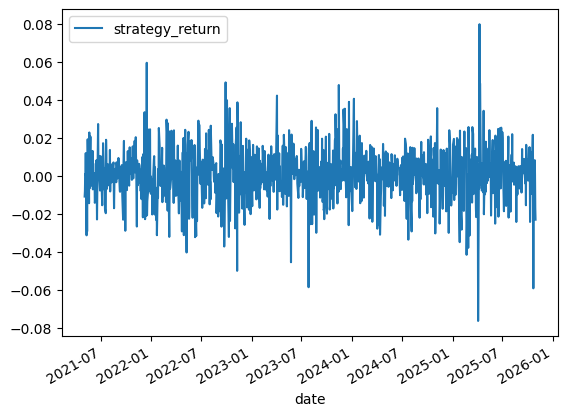

In [39]:
portfolio_df.plot()

In [40]:
spy_ret = data_scraper.get_sp500_data(tickers=['SPY'],
                                     start_date='2021-04-01',
                                     end_date='2025-11-01')
spy_ret = spy_ret.reset_index().drop('ticker', axis=1)
spy_ret['spy_ret'] = spy_ret['adj_close'].pct_change()
spy_ret = spy_ret[['date', 'spy_ret']]
spy_ret = spy_ret.set_index('date').dropna()
portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

c:\Users\kudam\Documents\Github\Finance\utils\data_scraper.py:130: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.stack()


Loaded S&P 500 historical data from 'data/sp500_data.csv'
Filtering data between 2021-04-01 and 2025-11-01
Filtering data for specified tickers


In [41]:
portfolio_df.to_csv('data/portfolio_returns.csv')

In [42]:
portfolio_df

,strategy_return,spy_ret
date,,
2021-05-03,-0.010944,0.002156
2021-05-04,-0.008191,-0.006169
2021-05-05,0.000844,0.000313
2021-05-06,0.000563,0.007985
2021-05-07,0.011941,0.007278
...,...,...
2025-10-24,-0.002247,0.008173
2025-10-27,0.008225,0.011798
2025-10-28,0.001019,0.002656


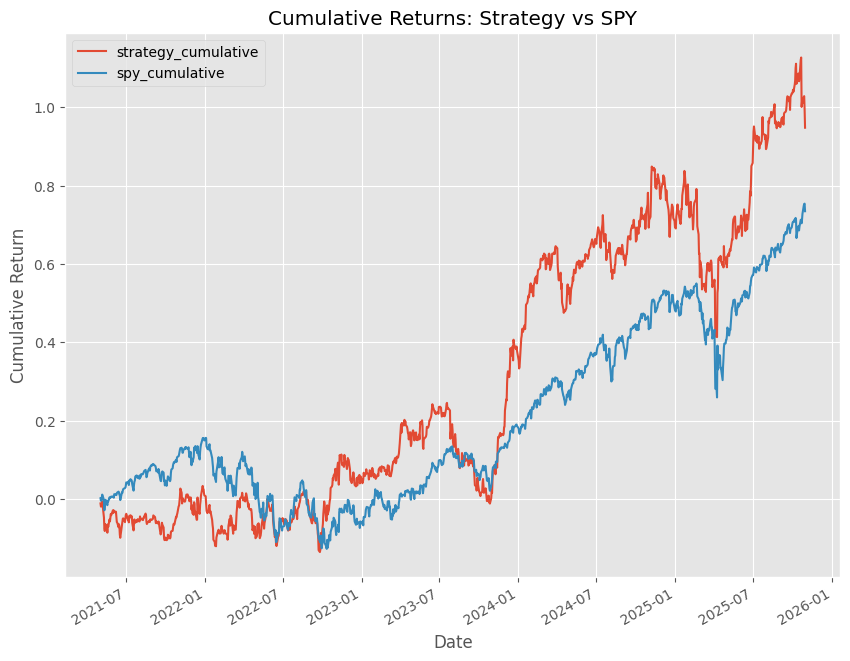

In [43]:
# Ensure portfolio_df has both simple-return columns
# 'strategy_return' should already exist; 'spy_ret' should have been merged earlier

# Sort and align
portfolio_df = portfolio_df.sort_index()

# Keep only rows where we have both returns (or choose fillna policy)
cum_input = portfolio_df[['strategy_return', 'spy_ret']].dropna()

# Daily cumulative simple returns
strategy_cum = (1 + cum_input['strategy_return']).cumprod() - 1
spy_cum      = (1 + cum_input['spy_ret']).cumprod() - 1

cum_df = pd.concat([strategy_cum, spy_cum], axis=1)
cum_df.columns = ['strategy_cumulative', 'spy_cumulative']

# Plot
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 8))
cum_df.plot(ax=ax)
ax.set_title("Cumulative Returns: Strategy vs SPY")
ax.set_ylabel("Cumulative Return")
ax.set_xlabel("Date")
plt.show()

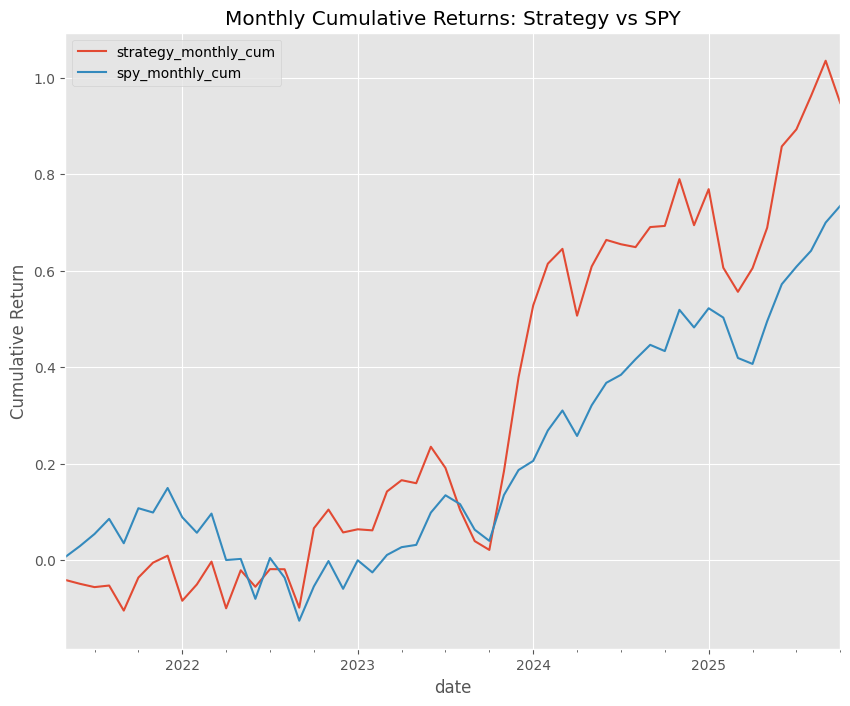

In [44]:
# Monthly simple returns from daily simple returns (product of (1+r) - 1)
monthly = (1 + cum_input['strategy_return']).resample('ME').apply(lambda x: x.prod()) - 1
monthly_spy = (1 + cum_input['spy_ret']).resample('ME').apply(lambda x: x.prod()) - 1

monthly_cum = (1 + monthly).cumprod() - 1
monthly_spy_cum = (1 + monthly_spy).cumprod() - 1

monthly_cum_df = pd.concat([monthly_cum, monthly_spy_cum], axis=1)
monthly_cum_df.columns = ['strategy_monthly_cum', 'spy_monthly_cum']

# Plot monthly cumulative
fig, ax = plt.subplots(figsize=(10, 8))
monthly_cum_df.plot(ax=ax)
ax.set_title("Monthly Cumulative Returns: Strategy vs SPY")
ax.set_ylabel("Cumulative Return")
plt.show()

In [45]:
# 1) Basic stats of daily strategy returns
print("Strategy return head / tail / describe:")
print(portfolio_df['strategy_return'].head())
print(portfolio_df['strategy_return'].tail())
print(portfolio_df['strategy_return'].describe())

# 2) Any extreme daily returns?
print("\nTop 10 largest strategy daily returns:")
print(portfolio_df['strategy_return'].nlargest(10))
print("\nTop 10 most negative strategy daily returns:")
print(portfolio_df['strategy_return'].nsmallest(10))

# 3) Check weight sums at each rebalance (if you still have `fixed_dates` & your stored `weights` per iteration, recompute)
# If you don't store weights history, recompute weights quickly from your optimisation loop's approach:
from collections import defaultdict
weight_sums = defaultdict(float)
# Recompute sums: iterate fixed_dates and reproduce weight calculation for that period (same as your loop)
for start_date in fixed_dates.keys():
    try:
        cols = fixed_dates[start_date]
        optimisation_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimisation_end_date   = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        optimisation_df = new_df.loc[optimisation_start_date:optimisation_end_date][cols]
        try:
            w = optimise_weights(prices=optimisation_df, lower_bound=round(1/len(optimisation_df.columns)*0.5, 3))
            w = pd.Series(w, index=optimisation_df.columns)
        except Exception:
            w = pd.Series(1/len(optimisation_df.columns), index=optimisation_df.columns)
        weight_sums[start_date] = w.sum()
    except Exception as e:
        weight_sums[start_date] = f"error: {e}"

ws = pd.Series(weight_sums)
print("\nWeight sums across rebalances (unique values / sample):")
print(ws.value_counts().head())
print(ws.head(10))

Strategy return head / tail / describe:
date
2021-05-03   -0.010944
2021-05-04   -0.008191
2021-05-05    0.000844
2021-05-06    0.000563
2021-05-07    0.011941
Name: strategy_return, dtype: float64
date
2025-10-24   -0.002247
2025-10-27    0.008225
2025-10-28    0.001019
2025-10-29   -0.016999
2025-10-30   -0.023115
Name: strategy_return, dtype: float64
count    1131.000000
mean        0.000685
std         0.013854
min        -0.076470
25%        -0.006852
50%         0.000912
75%         0.008256
max         0.079853
Name: strategy_return, dtype: float64

Top 10 largest strategy daily returns:
date
2025-04-09    0.079853
2021-12-15    0.059540
2022-09-28    0.049212
2025-04-11    0.048713
2023-11-14    0.047826
2023-04-03    0.042234
2024-01-08    0.040581
2022-10-03    0.039803
2023-12-21    0.038954
2022-11-10    0.038691
Name: strategy_return, dtype: float64

Top 10 most negative strategy daily returns:
date
2025-04-04   -0.076470
2025-10-22   -0.059279
2023-07-27   -0.058700
2022-

In [46]:
# cumulative portfolio value starting at 1.0
pv = (1 + portfolio_df['strategy_return']).cumprod()
final_return = pv.iloc[-1] - 1
print("Final cumulative return (total):", final_return)

Final cumulative return (total): 0.9474031424418203


In [47]:
N = len(portfolio_df)
cagr = pv.iloc[-1] ** (252 / N) - 1
print("Geometric annualized return (CAGR):", cagr)

Geometric annualized return (CAGR): 0.16009657688471535


In [48]:
ann_vol = portfolio_df['strategy_return'].std() * (252 ** 0.5)
ann_return_geo = (1 + portfolio_df['strategy_return']).prod() ** (252 / N) - 1
sharpe = ann_return_geo / ann_vol
print("Ann vol:", ann_vol, "Ann geom return:", ann_return_geo, "Sharpe ≈", sharpe)

Ann vol: 0.21992511986061603 Ann geom return: 0.16009657688471535 Sharpe ≈ 0.7279594845108246


In [49]:
cum = (1 + portfolio_df['strategy_return']).cumprod()
rolling_max = cum.cummax()
drawdown = (cum - rolling_max) / rolling_max
print("Max drawdown:", drawdown.min())

Max drawdown: -0.23536238594093484


In [50]:
print("Duplicate rows:", portfolio_df.index.duplicated().sum())

Duplicate rows: 0


In [51]:
print("Top 10 pos/neg days:", portfolio_df['strategy_return'].nlargest(10), portfolio_df['strategy_return'].nsmallest(10))

Top 10 pos/neg days: date
2025-04-09    0.079853
2021-12-15    0.059540
2022-09-28    0.049212
2025-04-11    0.048713
2023-11-14    0.047826
2023-04-03    0.042234
2024-01-08    0.040581
2022-10-03    0.039803
2023-12-21    0.038954
2022-11-10    0.038691
Name: strategy_return, dtype: float64 date
2025-04-04   -0.076470
2025-10-22   -0.059279
2023-07-27   -0.058700
2022-11-09   -0.050067
2023-05-24   -0.045540
2025-02-21   -0.041619
2022-05-09   -0.040404
2025-02-27   -0.037946
2022-09-23   -0.037254
2025-01-27   -0.034952
Name: strategy_return, dtype: float64


In [52]:
new_df.tail()

ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AMAT,AMD,...,V,VLO,VRTX,VZ,WDAY,WFC,WMT,WYNN,XOM,XYZ
date,,,,,,,,,,,,,,,,,,,,,
2025-10-24,262.565491,227.990005,126.849998,247.649994,353.519989,238.009995,280.940002,312.880005,228.302490,252.919998,...,346.693298,169.978149,421.390015,38.820000,242.750000,85.958069,106.169998,125.309982,114.389481,79.540001
2025-10-27,268.549652,228.029999,127.180000,250.770004,357.799988,243.009995,280.529999,313.529999,230.877441,259.670013,...,347.132416,173.257477,420.170013,39.230000,238.910004,86.554932,104.470001,125.180252,114.934715,80.150002
2025-10-28,268.739471,227.539993,126.610001,253.350006,359.910004,239.350006,279.630005,311.079987,227.194656,258.010010,...,346.214233,168.278854,422.390015,39.320000,236.929993,86.445503,103.169998,120.599754,114.032600,80.180000
2025-10-29,269.438812,225.139999,124.430000,247.750000,337.859985,235.039993,261.220001,297.079987,235.288788,264.329987,...,340.605347,169.590591,417.209991,40.209999,231.360001,85.550209,102.459999,120.619713,115.440285,76.510002
2025-10-30,271.137146,228.199997,124.669998,249.250000,339.239990,232.899994,261.529999,300.769989,232.095062,254.839996,...,344.347931,169.034103,419.890015,38.959999,232.869995,85.540260,102.230003,119.521988,113.695557,73.919998


In [53]:
max_date = new_df.index.max()

In [54]:
max_date

Timestamp('2025-10-30 00:00:00')

In [55]:
portfolio_size = 2000
new_portfolio = weights.stack(future_stack=True).to_frame('weight').reset_index(level=0, drop=True)
new_portfolio['allocation'] = new_portfolio['weight'] * portfolio_size
new_portfolio['shares'] = (new_portfolio['allocation'] / new_df.loc[max_date, new_portfolio.index]).astype(int)
new_portfolio['shares_cost'] = new_portfolio['shares'] * new_df.loc[max_date, new_portfolio.index] 
new_portfolio

,weight,allocation,shares,shares_cost
AMD,0.05000,100.0,0,0.000000
XYZ,0.05000,100.0,1,73.919998
TTD,0.05000,100.0,2,97.940002
MU,0.06535,130.7,0,0.000000
AMAT,0.05000,100.0,0,0.000000
F,0.05000,100.0,7,90.374805
CCL,0.05000,100.0,3,84.990000
KLAC,0.05000,100.0,0,0.000000
LRCX,0.53465,1069.3,6,966.059967
NVDA,0.05000,100.0,0,0.000000
